# TCGA / CPTAC B Cell Analysis

This Jupyter notebook contains the analysis code to estimate the effect of B cells on overall patient survival and signalling in the TCGA and CPTAC (where available) cohorts for human melanoma, lung adenocarinoma, lung squamous cell carcinomam, ovarian cancer, and breast cancer.

This notebook accompanies the publication of the ReactomeGSA analysis system.

In [1]:
# use a consistent working directory for the data - adapt if needed
working_directory <- "/home/jupyter-jg/B_cells_TCGA"

if (dir.exists(working_directory)) {
    setwd(working_directory)
} else {
    warning(working_directory, " does not exist. Leaving the working directory at ", getwd())
}

In [2]:
# load all required libraries
suppressPackageStartupMessages(library(SummarizedExperiment))
suppressPackageStartupMessages(library(TCGAbiolinks))
suppressPackageStartupMessages(library(edgeR))

# TCGA Data

## Helper functions

These functions represent the core analysis steps used to process the TCGA data from the different cohorts:

In [213]:
# consistently filter and pre-process TCGA datasets
pre_process_dge_data <- function(dge_experiment, min_counts = 10, min_rel_samples = 0.3) {
    # remove genes with < 10 counts and in < 0.3 of the samples
    rel_in_samples <- rowSums(dge_experiment$counts >= min_counts) / ncol(dge_experiment)
    dge_experiment_filtered <- dge_experiment[rel_in_samples >= min_rel_samples, ]

    message("Removed ", nrow(dge_experiment) - nrow(dge_experiment_filtered), 
            " genes observed in less than ", min_rel_samples, 
            " of the samples with ", min_counts, " read counts")
    message(nrow(dge_experiment_filtered), " genes retained")
    
    # change to gene identifiers
    gene_counts <- rowSums(dge_experiment_filtered$counts)
    dge_experiment_filtered <- dge_experiment_filtered[order(gene_counts, decreasing = T), ]
    dge_experiment_filtered <- dge_experiment_filtered[!duplicated(dge_experiment_filtered$genes$external_gene_name) & !is.na(dge_experiment_filtered$genes$external_gene_name), ]
    rownames(dge_experiment_filtered) <- dge_experiment_filtered$genes$external_gene_name

    return(dge_experiment_filtered)
}

# quantify the plasmablast-like B cell signature in TCGA datasets
add_signatures <- function(dge_experiment) {
    signatures <- list(
    "TIPB" = c("CD38", "CD27", "PAX5"),
    # Functional signatures
    "Activation" = c("CD69", "SELPLG", "CD72", "CFLAR", "FGFR1", "CD86"),
    "Co-Stimulation" = c("ICAM3", "TNFRSF13C", "CD40", "CD72", "C3",
                         "CD80", "CD86", "CD27", "CD28", "ICOS", "TNFRSF9",
                         "CD40LG", "ARHGDIB" ),
    "Immune-checkpoint" = c("CD274", "PDCD1LG2", "TNFRSF14", "LGALS9",
                            "BTLA", "LAG3", "HAVCR2", "ADORA2A"),
    "Exhaustion" = c("PDCD1", "FCRL4", "SIGLEC6", "CD22"),
    "Pro-Inflammation" = c("TNF", "IL12B", "IL18", "LTA", "TNFAIP2", "C3", "HCK"),
    "Cytokines-Immunsupp" = c("IL10", "TGFB1"))
    
    # quantify the B cell signatures
    suppressPackageStartupMessages(library(GSVA))

    quant_signatures <- gsva(expr = as.matrix(dge_experiment$counts), signatures, kcdf="Gaussian", method="ssgsea")
    
    # add the signatues to the sample annotations
    for (sig_name in rownames(quant_signatures)) {
        dge_experiment$samples[, sig_name] <- quant_signatures[sig_name, ]
    }
    
    return(dge_experiment)
}

# access the survival between TIPB high and low samples
assess_tipb_survival <- function(dge_experiment, plot.filename = NULL, plot.title = "Survival analysis"){
    # check survival
    library(survival)

    sample_groups <- factor(dge_experiment$samples$TIPB > median(dge_experiment$samples$TIPB),
                               levels = c(F,T),
                               labels = paste0("TIPB", c(" low", " high")))

    max_days <- ifelse(is.na(dge_experiment$samples$days_to_last_follow_up), 
                       dge_experiment$samples$days_to_death, 
                       dge_experiment$samples$days_to_last_follow_up)

    surv_obj <- Surv(max_days / 365, dge_experiment$samples$vital_status == "Dead")

    cols <- RColorBrewer::brewer.pal(9, "RdYlBu")
    col_down <- cols[2]
    cols_up <- cols[9]
    
    # adapt the plot size
    options(repr.plot.width = 5, repr.plot.height = 5)
    plot(survfit(surv_obj ~ sample_groups), col = c(col_down, cols_up), xlab = "Overall survival (years)",
            ylab = "Rel. patients alive", main = plot.title)

    legend("topright", legend = levels(sample_groups), lty = 1,
                                      col = c(col_down, cols_up))
    
    if (!is.null(plot.filename)) {
        svg(plot.filename, width = 5, height = 5)
        plot(survfit(surv_obj ~ sample_groups), col = c(col_down, cols_up), xlab = "Overall survival (years)",
            ylab = "Rel. patients alive", main = plot.title)

        legend("topright", legend = levels(sample_groups), lty = 1,
                                          col = c(col_down, cols_up))
        dev.off()
    }

    print(summary(coxph(surv_obj ~ sample_groups)))
    
    # add the sample groups
    dge_experiment$samples$tipb_group <- sample_groups
    
    return(dge_experiment)
}

## TCGA-LUAD

In [4]:
# find all lung adenocarcinoma files
query <- GDCquery(project = "TCGA-LUAD", legacy = FALSE, data.category = "Transcriptome Profiling", 
                  workflow.type = "HTSeq - Counts")

lung_count_files <- getResults(query)

message("Found ", nrow(lung_count_files), " samples")

# download the data
GDCdownload(query)

lung_counts <- GDCprepare(query)

# Create edgeR DGEList object
lung_dge <- DGEList(counts = assay(lung_counts), 
                    samples = colData(lung_counts), 
                    genes = rowData(lung_counts), 
                    group = colData(lung_counts)$vital_status)

saveRDS(lung_dge, file = "lung_dge_counts.rds")

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-LUAD

--------------------

oo Filtering results

--------------------

ooo By workflow.type

----------------

oo Checking data

----------------

ooo Check if there are duplicated cases

ooo Check if there results for the query

-------------------

o Preparing output

-------------------

Found 594 samples


Of the 594 files for download 594 already exist.

All samples have been already downloaded



|====================================================|100%                      Completed after 54 s 


Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

luad subtype information from:doi:10.1038/nature13385

Accessing www.ensembl.org to get gene information


Cache found

From the 60483 genes we couldn't map 3984



In [165]:
lung_dge <- readRDS("lung_dge_counts.rds")

# only keep primary tumors
lung_dge <- lung_dge[, lung_dge$samples$shortLetterCode == "TP"]

# preproces the data
lung_dge_filtered <- pre_process_dge_data(lung_dge)

# quantify the B cell signatures
lung_dge_filtered <- add_signatures(lung_dge_filtered)

Call:
coxph(formula = surv_obj ~ sample_groups)

  n= 524, number of events= 188 
   (9 observations deleted due to missingness)

                          coef exp(coef) se(coef)      z Pr(>|z|)  
sample_groupsTIPB high -0.3018    0.7395   0.1473 -2.049   0.0405 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                       exp(coef) exp(-coef) lower .95 upper .95
sample_groupsTIPB high    0.7395      1.352     0.554     0.987

Concordance= 0.543  (se = 0.02 )
Likelihood ratio test= 4.23  on 1 df,   p=0.04
Wald test            = 4.2  on 1 df,   p=0.04
Score (logrank) test = 4.23  on 1 df,   p=0.04



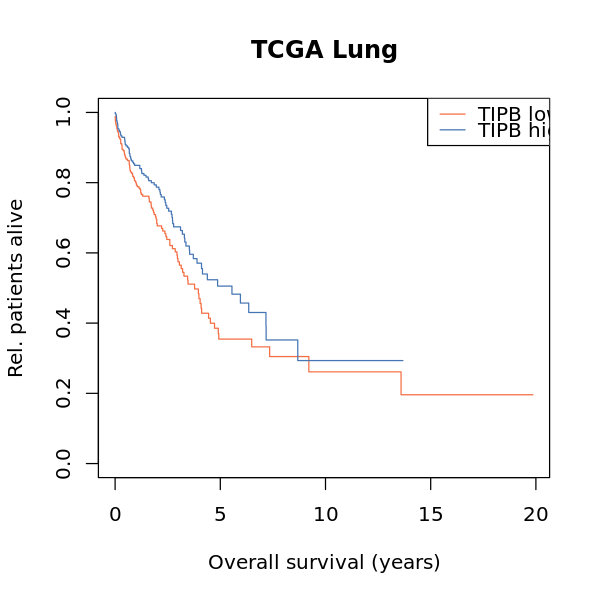

In [214]:
# ass the survival
lung_dge_filtered <- assess_tipb_survival(lung_dge_filtered, plot.filename = "survival_TCGA_lung.svg", plot.title = "TCGA Lung")

In [ ]:
saveRDS(lung_dge_filtered, file = "lung_dge_filtered.rds")

## TCGA-SKCM

In [6]:
mel_query <- GDCquery(project = "TCGA-SKCM", legacy = FALSE, data.category = "Transcriptome Profiling", 
                  workflow.type = "HTSeq - Counts")

# get the files
mel_count_files <- getResults(query)

# download the files
GDCdownload(mel_query)

# create the object
mel_counts <- GDCprepare(mel_query)

# create the DGEList object
mel_dge <- DGEList(counts = assay(mel_counts), 
                    samples = colData(mel_counts), 
                    genes = rowData(mel_counts), 
                    group = colData(mel_counts)$vital_status)

saveRDS(mel_dge, file="mel_dge_counts.rds")

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-SKCM

--------------------

oo Filtering results

--------------------

ooo By workflow.type

----------------

oo Checking data

----------------

ooo Check if there are duplicated cases

ooo Check if there results for the query

-------------------

o Preparing output

-------------------


Of the 472 files for download 472 already exist.

All samples have been already downloaded



|====================================================|100%                      Completed after 37 s 


Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

skcm subtype information from:doi:10.1016/j.cell.2015.05.044

Accessing www.ensembl.org to get gene information


Cache found

From the 60483 genes we couldn't map 3984



In [7]:
# load the melanoma data if not present
mel_dge <- readRDS("mel_dge_counts.rds")

mel_dge <- pre_process_dge_data(mel_dge)

mel_dge <- add_signatures(mel_dge)

Call:
coxph(formula = surv_obj ~ sample_groups)

  n= 463, number of events= 222 
   (9 observations deleted due to missingness)

                          coef exp(coef) se(coef)      z Pr(>|z|)    
sample_groupsTIPB high -0.5752    0.5626   0.1365 -4.215  2.5e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                       exp(coef) exp(-coef) lower .95 upper .95
sample_groupsTIPB high    0.5626      1.778    0.4305    0.7351

Concordance= 0.579  (se = 0.018 )
Likelihood ratio test= 18.07  on 1 df,   p=2e-05
Wald test            = 17.77  on 1 df,   p=2e-05
Score (logrank) test = 18.25  on 1 df,   p=2e-05



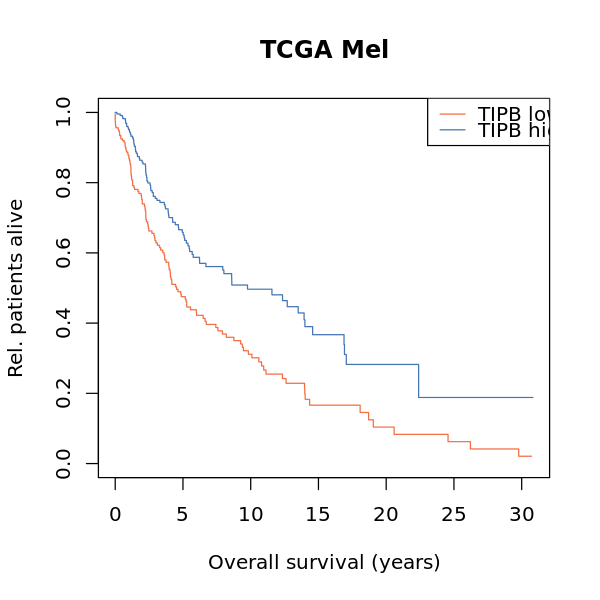

In [215]:
mel_dge <- assess_tipb_survival(mel_dge, plot.filename = "survival_TCGA_mel.svg", plot.title = "TCGA Mel")

In [7]:
saveRDS(mel_dge, file="mel_dge_filtered.rds")

## TCGA-BRCA

In [8]:
# TCGA-BRCA
library(TCGAbiolinks)

# download RNASeq data
breast_query <- GDCquery(
    project = "TCGA-BRCA",
    data.category = "Transcriptome Profiling",
    data.type = "Gene Expression Quantification",
    workflow.type = "HTSeq - Counts"
)

GDCdownload(breast_query)

# Note: this currently fails, therefore I'm using the data from 18-01
breast_counts <- GDCprepare(breast_query)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BRCA

--------------------

oo Filtering results

--------------------

ooo By data.type

ooo By workflow.type

----------------

oo Checking data

----------------

ooo Check if there are duplicated cases

ooo Check if there results for the query

-------------------

o Preparing output

-------------------


Of the 1222 files for download 1222 already exist.

All samples have been already downloaded



|====================================================|100%                      Completed after 2 m 


Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

brca subtype information from:doi.org/10.1016/j.ccell.2018.03.014

Accessing www.ensembl.org to get gene information


Cache found

From the 60483 genes we couldn't map 3984



In [9]:
table(breast_counts$sample_type)


         Metastatic       Primary Tumor Solid Tissue Normal 
                  7                1102                 113 

In [10]:
# limit to primary tumors
message("Limiting to primary tumours...")
breast_counts <- breast_counts[, breast_counts$sample_type == "Primary Tumor"]

message("Retained ", ncol(breast_counts), " samples")

Limiting to primary tumours...

Retained 1102 samples



In [11]:
# create the object
breast_dge <- DGEList(counts = assay(breast_counts), 
                    samples = colData(breast_counts), 
                    genes = rowData(breast_counts), 
                    group = colData(breast_counts)$vital_status)

saveRDS(breast_dge, file="breast_dge_counts.rds")

In [12]:
# use previously prepare version
breast_dge <- readRDS("breast_dge_counts.rds")

breast_dge <- pre_process_dge_data(breast_dge)
breast_dge <- add_signatures(breast_dge)

Call:
coxph(formula = surv_obj ~ sample_groups)

  n= 1101, number of events= 154 
   (1 observation deleted due to missingness)

                          coef exp(coef) se(coef)      z Pr(>|z|)
sample_groupsTIPB high -0.2202    0.8024   0.1630 -1.351    0.177

                       exp(coef) exp(-coef) lower .95 upper .95
sample_groupsTIPB high    0.8024      1.246    0.5829     1.104

Concordance= 0.539  (se = 0.024 )
Likelihood ratio test= 1.84  on 1 df,   p=0.2
Wald test            = 1.83  on 1 df,   p=0.2
Score (logrank) test = 1.83  on 1 df,   p=0.2



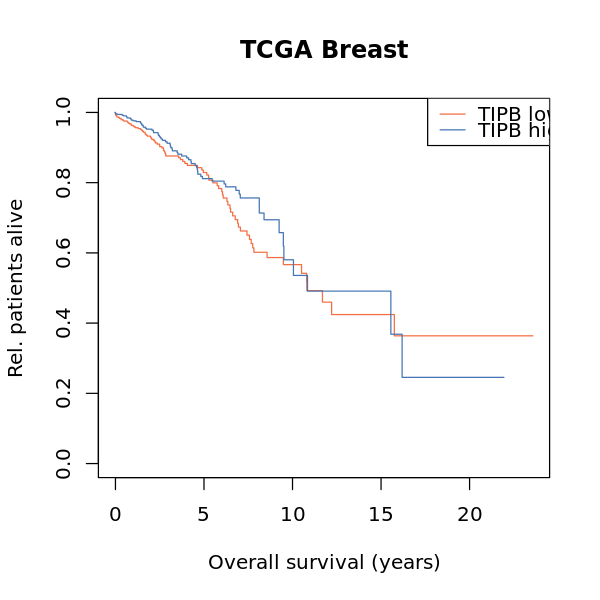

In [321]:
# breast_dge$samples$vital_status[breast_dge$samples$vital_status == "dead"] <- "Dead"
breast_dge <- assess_tipb_survival(breast_dge, plot.filename = "survival_TCGA_breast.svg", "TCGA Breast")

In [ ]:
saveRDS(breast_dge, file = "breast_dge_filtered.rds", plot.filename = "survival_TCGA_breast.svg", plot.title = "TCGA Breast")

## TCGA-LUSC

In [54]:
library(TCGAbiolinks)

# download RNASeq data
lung_scc_query <- GDCquery(
    project = "TCGA-LUSC",
    data.category = "Transcriptome Profiling",
    data.type = "Gene Expression Quantification",
    workflow.type = "HTSeq - Counts"
)

GDCdownload(lung_scc_query)

lung_scc_counts <- GDCprepare(lung_scc_query)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-LUSC

--------------------

oo Filtering results

--------------------

ooo By data.type

ooo By workflow.type

----------------

oo Checking data

----------------

ooo Check if there are duplicated cases

ooo Check if there results for the query

-------------------

o Preparing output

-------------------


GDCdownload will download 551 files. A total of 140.276146 MB




|====================================================|100%                      Completed after 50 s 


Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

lusc subtype information from:doi:10.1038/nature11404

Accessing www.ensembl.org to get gene information


Cache found

From the 60483 genes we couldn't map 3984



In [55]:
table(lung_scc_counts$sample_type)


      Primary Tumor Solid Tissue Normal 
                502                  49 

In [58]:
# limit to primary tumors
lung_scc_counts <- lung_scc_counts[, lung_scc_counts$sample_type == "Primary Tumor"]

In [ ]:
# create the object
lung_scc_dge <- DGEList(counts = assay(lung_scc_counts), 
                    samples = colData(lung_scc_counts), 
                    genes = rowData(lung_scc_counts), 
                    group = colData(lung_scc_counts)$vital_status)

saveRDS(lung_scc_dge, file="lung_scc_dge_counts.rds")

In [60]:
# use previously prepare version
lung_scc_dge <- readRDS("lung_scc_dge_counts.rds")

lung_scc_dge <- pre_process_dge_data(lung_scc_dge)
lung_scc_dge <- add_signatures(lung_scc_dge)

Call:
coxph(formula = surv_obj ~ sample_groups)

  n= 496, number of events= 212 
   (6 observations deleted due to missingness)

                          coef exp(coef) se(coef)     z Pr(>|z|)
sample_groupsTIPB high 0.02058   1.02079  0.13807 0.149    0.882

                       exp(coef) exp(-coef) lower .95 upper .95
sample_groupsTIPB high     1.021     0.9796    0.7788     1.338

Concordance= 0.501  (se = 0.019 )
Likelihood ratio test= 0.02  on 1 df,   p=0.9
Wald test            = 0.02  on 1 df,   p=0.9
Score (logrank) test = 0.02  on 1 df,   p=0.9



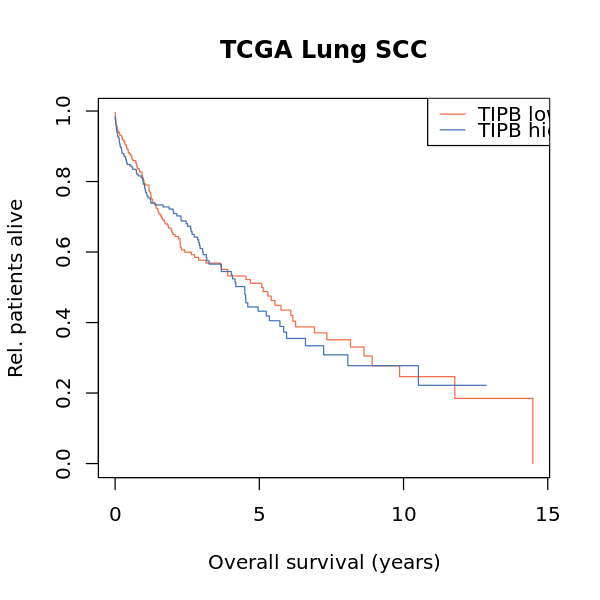

In [217]:
# breast_dge$samples$vital_status[breast_dge$samples$vital_status == "dead"] <- "Dead"
lung_scc_dge <- assess_tipb_survival(lung_scc_dge, plot.filename = "survival_TCGA_lung_scc.svg", plot.title = "TCGA Lung SCC")

In [ ]:
saveRDS(lung_scc_dge, file = "lung_scc_dge_filtered.rds")

## TCGA-OV

In [81]:
library(TCGAbiolinks)

# download RNASeq data
ovarian_query <- GDCquery(
    project = "TCGA-OV",
    data.category = "Transcriptome Profiling",
    data.type = "Gene Expression Quantification",
    workflow.type = "HTSeq - Counts"
)

GDCdownload(ovarian_query)

# Note: this currently fails, therefore I'm using the data from 18-01
ovarian_counts <- GDCprepare(ovarian_query)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-OV

--------------------

oo Filtering results

--------------------

ooo By data.type

ooo By workflow.type

----------------

oo Checking data

----------------

ooo Check if there are duplicated cases

ooo Check if there results for the query

-------------------

o Preparing output

-------------------


GDCdownload will download 379 files. A total of 97.709866 MB




|====================================================|100%                      Completed after 33 s 


Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

Accessing www.ensembl.org to get gene information

Accessing www.ensembl.org (mirror useast)


Cache found

From the 60483 genes we couldn't map 3984



In [82]:
table(ovarian_counts$sample_type)


  Primary Tumor Recurrent Tumor 
            374               5 

In [83]:
# limit to primary tumors
ovarian_counts <- ovarian_counts[, ovarian_counts$sample_type == "Primary Tumor"]

In [84]:
# create the object
ovarian_dge <- DGEList(counts = assay(ovarian_counts), 
                    samples = colData(ovarian_counts), 
                    genes = rowData(ovarian_counts), 
                    group = colData(ovarian_counts)$vital_status)

saveRDS(ovarian_dge, file="ov_dge_counts.rds")

In [85]:
# use previously prepare version
ovarian_dge <- readRDS("ov_dge_counts.rds")

ovarian_dge <- pre_process_dge_data(ovarian_dge)
ovarian_dge <- add_signatures(ovarian_dge)

Call:
coxph(formula = surv_obj ~ sample_groups)

  n= 373, number of events= 230 
   (1 observation deleted due to missingness)

                          coef exp(coef) se(coef)     z Pr(>|z|)   
sample_groupsTIPB high -0.3743    0.6878   0.1346 -2.78  0.00543 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                       exp(coef) exp(-coef) lower .95 upper .95
sample_groupsTIPB high    0.6878      1.454    0.5283    0.8955

Concordance= 0.524  (se = 0.019 )
Likelihood ratio test= 7.85  on 1 df,   p=0.005
Wald test            = 7.73  on 1 df,   p=0.005
Score (logrank) test = 7.82  on 1 df,   p=0.005



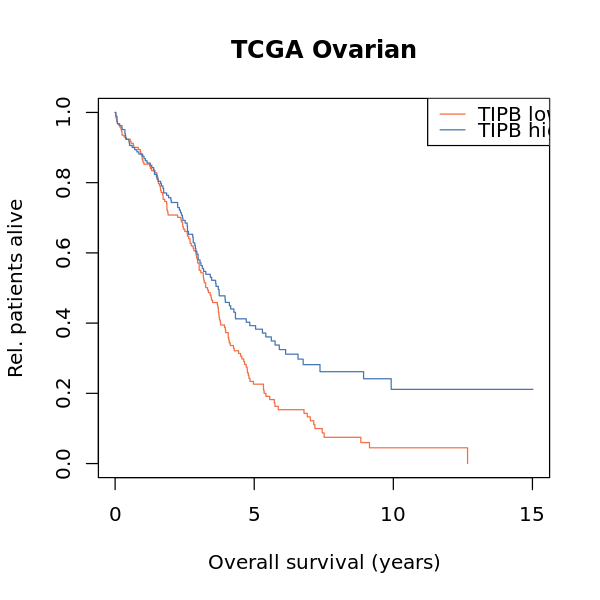

In [218]:
# breast_dge$samples$vital_status[breast_dge$samples$vital_status == "dead"] <- "Dead"
ovarian_dge <- assess_tipb_survival(ovarian_dge, plot.filename = "survival_TCGA_ov.svg", plot.title = "TCGA Ovarian")

In [ ]:
saveRDS(ovarian_dge, file = "ov_dge_filtered.rds")

# Comparative pathway analysis (ReactomeGSA)

Here, we use the ReactomeGSA Bioconductor R package to perform a comparative pathway analysis of the five TCGA datasets.

This requires three steps:

  1. Create the `ReactomeAnalysisRequest` object where the analysis method (PADOG) is specified
  2. Set default parameters for all datasets (include protein-protein interactors and ignore disease pathways)
  3. Add each dataset comparing the "TIPB high" vs the "TIPB low" group.

In [93]:
# run the pathway analysis
library(ReactomeGSA)

analysis_request <- ReactomeAnalysisRequest(method = "PADOG")
analysis_request <- set_parameters(analysis_request, use_interactors = T, include_disease_pathways = F)
analysis_request <- add_dataset(analysis_request, expression_values = lung_dge_filtered, 
                                name = "TCGA Lung", type = "rnaseq_counts", comparison_factor = "tipb_group", 
                                comparison_group_1 = "TIPB low", comparison_group_2 =  "TIPB high")

analysis_request <- add_dataset(analysis_request, expression_values = mel_dge, 
                                name = "TCGA Mel", type = "rnaseq_counts", comparison_factor = "tipb_group", 
                                comparison_group_1 = "TIPB low", comparison_group_2 =  "TIPB high")

analysis_request <- add_dataset(analysis_request, expression_values = ovarian_dge, 
                                name = "TCGA Ov", type = "rnaseq_counts", comparison_factor = "tipb_group", 
                                comparison_group_1 = "TIPB low", comparison_group_2 =  "TIPB high")

analysis_request <- add_dataset(analysis_request, expression_values = breast_dge, 
                                name = "TCGA Breast", type = "rnaseq_counts", comparison_factor = "tipb_group", 
                                comparison_group_1 = "TIPB low", comparison_group_2 =  "TIPB high")

analysis_request <- add_dataset(analysis_request, expression_values = lung_scc_dge, 
                                name = "TCGA Lung SCC", type = "rnaseq_counts", comparison_factor = "tipb_group", 
                                comparison_group_1 = "TIPB low", comparison_group_2 =  "TIPB high")

saveRDS(analysis_request, "reactome_analysis_request.rds")

Converting expression data to string... (This may take a moment)

Conversion complete

Converting expression data to string... (This may take a moment)

Conversion complete

Converting expression data to string... (This may take a moment)

Conversion complete

Converting expression data to string... (This may take a moment)

Conversion complete

Converting expression data to string... (This may take a moment)

Conversion complete



The ReactomeGSA analysis is launched through the single `perform_reactome_analysis` function. Depending on the load of the ReactomeGSA analysis system, this analysis takes between 30 - 60 minutes. Therefore, the analysis result is immediately cached as an `rds` file.

In [94]:
library(ReactomeGSA)
analysis_request <- readRDS("reactome_analysis_request.rds")

analysis_result <- perform_reactome_analysis(analysis_request)

saveRDS(analysis_result, file="reactome_analysis_result.rds")

Submitting request to Reactome API...

Reactome Analysis submitted succesfully

Queued

Converting dataset TCGA Lung...

Converting dataset TCGA Mel...

Converting dataset TCGA Ov...

Converting dataset TCGA Breast...

Converting dataset TCGA Lung SCC...

Mapping identifiers...

Performing gene set analysis using PADOG

Analysing dataset 'TCGA Lung' using PADOG

Analysing dataset 'TCGA Mel' using PADOG

Analysing dataset 'TCGA Ov' using PADOG

Analysing dataset 'TCGA Breast' using PADOG

Analysing dataset 'TCGA Lung SCC' using PADOG

Retrieving result...



The analysis result contains the pathway results for every analysed sample, as well as a link to the interactive visualization of the pathway analysis results in the Reactome PathwayBrowser (NOTE: The link contained in this notebook is no longer working as results are only stored for 1 week).

In [95]:
analysis_result <- readRDS("reactome_analysis_result.rds")
analysis_result

ReactomeAnalysisResult object
  Reactome Release: 72
  Results:
  - TCGA Lung:
    1801 pathways
    12241 fold changes for genes
  - TCGA Mel:
    1800 pathways
    11854 fold changes for genes
  - TCGA Ov:
    1801 pathways
    12325 fold changes for genes
  - TCGA Breast:
    1801 pathways
    12174 fold changes for genes
  - TCGA Lung SCC:
    1801 pathways
    12381 fold changes for genes
  Reactome visualizations:
  - Gene Set Analysis Summary

The `pathways` function returns a table with the merged pathway results of all analysed datasets.

We only keep pathways that were significantly regulated (FDR < 0.1) in at least one of the datasets.

In [174]:
pathway_data <- pathways(analysis_result)

# only keep significant pathways
max_fdr <- 0.1

# get significant pathways
sig_pathway <- c()
fdr_cols <- colnames(pathway_data)[grep("FDR", colnames(pathway_data))]

for (fdr_col in fdr_cols) {
    is_sig <- pathway_data[, fdr_col] < max_fdr & !is.na(pathway_data[, fdr_col])
    
    sig_pathway <- c(sig_pathway, rownames(pathway_data)[is_sig])
}

sig_pathway <- unique(sig_pathway)

message(length(sig_pathway), " significant pathways")

pathway_data <- pathway_data[sig_pathway, ]

383 significant pathways



In [ ]:
# save supplementary data
suppressPackageStartupMessages(library(xlsx))
write.xlsx(pathway_data, file = "Supplementary_Data_1.xlsx", sheetName = "Regulated Pathways")

Next, we only keep pathways that show a different regulation in any of the datasets compared to melanoma. For melanoma, multiple studies already showed the importance of B cells in the anti-tumour immunity. Therefore, we use the melanoma dataset as a reference.

In [190]:
# select pathways that are different to melanoma
diff_pathways_mel <- c()

direction_cols <- colnames(pathway_data)[grep("Direction", colnames(pathway_data))]

for (cur_col in direction_cols) {
    if (cur_col == "Direction.TCGA Mel") {
        next
    }
    
    message("Comparing ", cur_col, " with Melanoma")
    
    # get diff pathways
    dataset_diff_pathways <- rownames(pathway_data)[pathway_data[, cur_col] != pathway_data[, "Direction.TCGA Mel"]]
    
    diff_pathways_mel <- c(diff_pathways_mel, dataset_diff_pathways)
}

diff_pathways_mel <- unique(diff_pathways_mel)

message("Found ", length(diff_pathways_mel), " different pathways")

Comparing Direction.TCGA Lung with Melanoma

Comparing Direction.TCGA Ov with Melanoma

Comparing Direction.TCGA Breast with Melanoma

Comparing Direction.TCGA Lung SCC with Melanoma

Found 64 different pathways



The analysis result can be visualised in Reactome's pathway browser.

**Note**: The link shown in this notebook no longer works since results are only stored for 1 week on the Reactome server.

In [99]:
open_reactome(analysis_result)

Opening https://dev.reactome.org/PathwayBrowser/#/DTAB=AN&ANALYSIS=MjAyMDA0MDIwNzMyMDJfNjU%3D in the default browser...



url 
"https://dev.reactome.org/PathwayBrowser/#/DTAB=AN&ANALYSIS=MjAyMDA0MDIwNzMyMDJfNjU%3D"

Since lung adenocarcinoma samples are the only ones that show a down-regulation of NFkappaB activation, only pathways that are significant in lung adenocarcinoma and melanoma are shown in the subsequent heatmap.

png 
  2

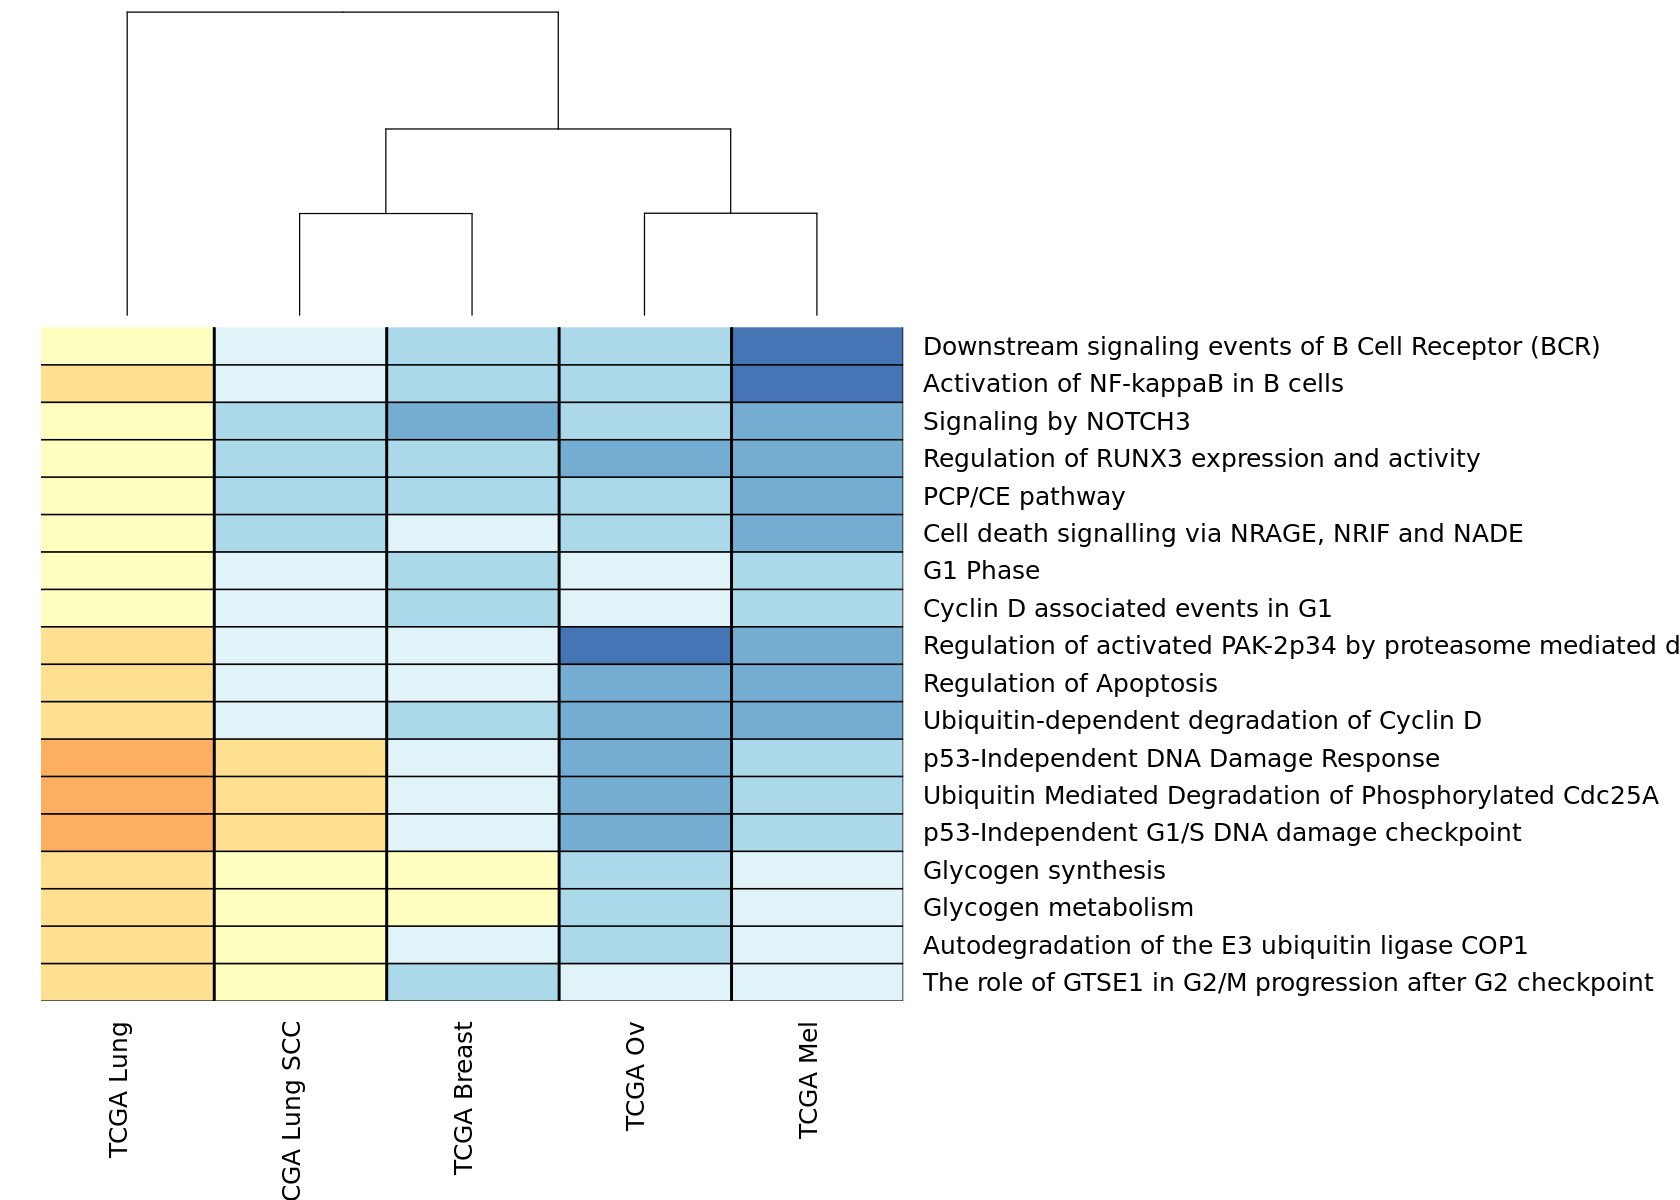

In [204]:
# limit to pathway significant in melanoma and lung
sig_mel_lung_pathways <- rownames(pathway_data)[pathway_data[, "FDR.TCGA Lung"] < 0.1 & pathway_data[, "FDR.TCGA Mel"] < 0.1]
heatmap_pathways <- sig_mel_lung_pathways[sig_mel_lung_pathways %in% diff_pathways_mel]

pathway_fc <- pathway_data[heatmap_pathways, grep("av_foldchange", colnames(pathway_data))]
colnames(pathway_fc) <- gsub(".*\\.", "", colnames(pathway_fc))
rownames(pathway_fc) <- pathway_data[heatmap_pathways, "Name"]

options(repr.plot.width = 14, repr.plot.height = 10)
gplots::heatmap.2(as.matrix(pathway_fc),
                margins = c(10, 39), 
                density.info = "none", 
                trace = "none",
                col = RColorBrewer::brewer.pal(9, "RdYlBu"),
                dendrogram = "col",
                key = FALSE, # don't display the color key
                lwid=c(0.1,4),  # remove the white space on the left
                 cexCol = 1.5,
                 cexRow = 1.5,
                 rowsep=1:nrow(pathway_fc),
                  colsep=1:ncol(pathway_fc),
                 sepcolor = "black",
                 sepwidth = c(0.01, 0.01))

svg("TCGA_TIBP_diff_pathway_heatmap.svg", width = 14, height = 10)
gplots::heatmap.2(as.matrix(pathway_fc),
                margins = c(10, 39), 
                density.info = "none", 
                trace = "none",
                col = RColorBrewer::brewer.pal(9, "RdYlBu"),
                dendrogram = "col",
                key = FALSE, # don't display the color key
                lwid=c(0.1,4),  # remove the white space on the left
                 cexCol = 1.5,
                 cexRow = 1.5,
                 rowsep=1:nrow(pathway_fc),
                  colsep=1:ncol(pathway_fc),
                 sepcolor = "black",
                 sepwidth = c(0.01, 0.01))
dev.off()

In [202]:
pathway_fc

,TCGA Lung,TCGA Mel,TCGA Ov,TCGA Breast,TCGA Lung SCC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"Cell death signalling via NRAGE, NRIF and NADE",-0.001296796,0.05968023,0.03358828,0.0259963000,0.0281564346
Signaling by NOTCH3,-0.001212035,0.06161943,0.03648004,0.0533652200,0.0330781040
Cyclin D associated events in G1,-0.003557852,0.04530787,0.02200890,0.0401993100,0.0213052037
G1 Phase,-0.003557852,0.04530787,0.02200890,0.0401993100,0.0213052037
PCP/CE pathway,-0.002164707,0.05532647,0.03880346,0.0352533500,0.0296437756
Downstream signaling events of B Cell Receptor (BCR),-0.008275775,0.08316863,0.04522575,0.0446416900,0.0252323404
The role of GTSE1 in G2/M progression after G2 checkpoint,-0.013629120,0.02302665,0.02229051,0.0329598000,0.0016541485
Activation of NF-kappaB in B cells,-0.011877540,0.08030799,0.04409536,0.0437731900,0.0197654841
Regulation of activated PAK-2p34 by proteasome mediated degradation,-0.019122020,0.05577306,0.06578521,0.0268113600,0.0184071232


In [320]:
pathway_data[sig_mel_lung_pathways, grepl("FDR", colnames(pathway_data)) | grepl("Name", colnames(pathway_data))]

,Name,FDR.TCGA Lung,FDR.TCGA Mel,FDR.TCGA Ov,FDR.TCGA Breast,FDR.TCGA Lung SCC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R-HSA-1280218,Adaptive Immune System,1e-05,1e-05,1e-05,0.00100,0.00100
R-HSA-198933,Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell,1e-05,1e-05,1e-05,0.00001,0.00001
R-HSA-202733,Cell surface interactions at the vascular wall,1e-05,1e-05,1e-05,0.00001,0.00001
R-HSA-2029480,Fcgamma receptor (FCGR) dependent phagocytosis,1e-05,1e-05,1e-05,0.00001,0.00001
R-HSA-2029482,Regulation of actin dynamics for phagocytic cup formation,1e-05,1e-05,1e-05,0.00001,0.00200
R-HSA-2029485,Role of phospholipids in phagocytosis,1e-05,1e-05,1e-05,0.00001,0.00100
R-HSA-2871809,FCERI mediated Ca+2 mobilization,1e-05,1e-05,1e-05,0.00001,0.00001
R-HSA-983695,Antigen activates B Cell Receptor (BCR) leading to generation of second messengers,1e-05,1e-05,1e-05,0.00001,0.00001
R-HSA-109582,Hemostasis,1e-05,1e-05,1e-05,0.00100,0.00001


In [ ]:
plot_volcano(analysis_result)
plot_volcano(analysis_result, 2)

In [ ]:
plot_correlations(analysis_result)

# CPTAC Proteomics Data

List of CPTAC studies: https://cptac-data-portal.georgetown.edu/cptac/public?scope=Phase+II+%2525

## CPTAC Breast Cancer study

Protein summary file downloaded from https://cptac-data-portal.georgetown.edu/cptac/s/S015

In [250]:
suppressPackageStartupMessages( library(data.table) )
raw_data <- fread("cptac/TCGA_Breast_BI_Proteome.itraq.tsv")

# only keep the unshared log ratio
cols_to_keep <- colnames(raw_data)[grep("Unshared Log Ratio", colnames(raw_data))]

raw_data <- raw_data[, c("Gene", cols_to_keep), with = F]

# remove the first three statistical columns
raw_data <- raw_data[4:nrow(raw_data), ]

# change column names to only keep the id
colnames(raw_data) <- gsub(" Unshared Log Ratio", "", colnames(raw_data))

head(raw_data)

Gene,263d3f-I,blcdb9-I,c4155b-C,A2-A0D0-01A,BH-A0HK-01A,C8-A12T-01A,A2-A0D2-01A,C8-A12U-01A,AR-A1AS-01A,⋯,BH-A0BZ-01A,D8-A13Y-01A,A8-A076-01A,AO-A126-01A,E2-A10A-01A,BH-A18Q-01A,C8-A130-01A,E2-A159-01A,A2-A0T3-01A,A2-A0YD-01A
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,1.5304836,2.0134018,2.43518067,0.7612967,1.4187303,0.31752229,0.01254082,-0.08976698,-0.2901808,⋯,0.8599757,0.4872583,-0.73151739,-0.002832973,0.1776139,0.07737448,0.09946451,0.7524856,0.01267110,0.9942552
A2M,1.4286289,2.5877465,2.47657138,0.7476052,0.9251512,-0.01427574,-0.07196527,0.10803832,-0.5117369,⋯,0.8584047,-0.2538170,-0.72213981,-0.813984547,0.2877063,-0.02587743,-0.52492681,0.5558745,-0.65545195,0.4065023
A2ML1,-0.4314003,-0.4142286,0.01144029,-2.2230664,-1.8530141,-1.71109892,-0.33560987,-0.70042343,-0.7910894,⋯,-1.5277496,NA,NA,NA,-0.7883766,0.74341947,-0.56977743,3.3274639,-0.34600715,-0.1583337
AAAS,0.3335354,0.5456872,0.08208708,1.3754170,0.6707585,0.16332365,0.38059735,-0.13652292,0.1643583,⋯,0.6728346,0.5933650,0.06541163,0.170303794,0.8683271,0.25128313,-0.04026868,0.8933234,0.07965811,0.1481724
AACS,0.4930500,-0.2193542,0.02173741,-0.1955155,-0.5634773,-0.13320152,-0.54199389,-0.04899513,-0.1541032,⋯,-0.4742140,-0.1012545,0.25724345,0.449200282,-0.8211528,-0.38396223,-0.37580218,-1.0013509,-0.55486079,-0.4924700
AADAT,NA,NA,NA,NA,NA,NA,0.74487717,-1.28826047,-1.5060333,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [251]:
head(colnames(breast_dge))

[1] "TCGA-AR-A255-01A-11R-A169-07" "TCGA-BH-A0HB-01A-11R-A056-07"
[3] "TCGA-BH-A0W4-01A-11R-A109-07" "TCGA-B6-A0IJ-01A-11R-A034-07"
[5] "TCGA-E9-A1R0-01A-22R-A16F-07" "TCGA-A2-A0CR-01A-11R-A22K-07"

In [255]:
# match to TCGA samples
breast_dge$samples$short_id <- substr(gsub("TCGA-", "", colnames(breast_dge)), 1, 11)

head(breast_dge$samples$short_id)

[1] "AR-A255-01A" "BH-A0HB-01A" "BH-A0W4-01A" "B6-A0IJ-01A" "E9-A1R0-01A"
[6] "A2-A0CR-01A"

In [256]:
# only retain proteomics samples that exist
raw_sample_ids <- colnames(raw_data)[2:ncol(raw_data)]
samples_to_retain <- raw_sample_ids[raw_sample_ids %in% breast_dge$samples$short_id]

matched_data <- raw_data[, c("Gene", samples_to_retain), with = F]

message("Retained ", length(samples_to_retain), " proteomics samples")

Retained 99 proteomics samples



In [261]:
# create the sample data.frame for the pathway analysis
sample_data <- data.frame(
    row.names = colnames(matched_data)[2:ncol(matched_data)],
    id = colnames(matched_data)[2:ncol(matched_data)]
)

# add the TIPB group
sample_data$TIPB <- plyr::mapvalues(x = sample_data$id, from = breast_dge$samples$short_id, to = breast_dge$samples$TIPB, warn_missing = F)
sample_data$tipb_group <- plyr::mapvalues(x = sample_data$id, from = breast_dge$samples$short_id, to = as.character(breast_dge$samples$tipb_group), warn_missing = F)

head(sample_data)

,id,TIPB,tipb_group
,<fct>,<fct>,<fct>
A2-A0D0-01A,A2-A0D0-01A,-0.176238075185544,TIPB high
BH-A0HK-01A,BH-A0HK-01A,-0.153623237806923,TIPB high
C8-A12T-01A,C8-A12T-01A,-0.24809236081229,TIPB low
A2-A0D2-01A,A2-A0D2-01A,-0.0431269296544915,TIPB high
C8-A12U-01A,C8-A12U-01A,-0.0338850882203674,TIPB high
AR-A1AS-01A,AR-A1AS-01A,-0.486517022310488,TIPB low


In [264]:
# change the expression data to a data.frame to support row.names
prot_exp_data <- data.frame(matched_data[, 2:ncol(matched_data), with = F])
rownames(prot_exp_data) <- matched_data$Gene

In [269]:
# create the ReactomeGSA request
library(ReactomeGSA)
breast_analysis_request <- ReactomeAnalysisRequest(method = "PADOG")
breast_analysis_request <- set_parameters(breast_analysis_request, use_interactors = T, include_disease_pathways = F)

breast_analysis_request <- add_dataset(breast_analysis_request, expression_values = breast_dge, 
                                name = "TCGA Breast", type = "rnaseq_counts", comparison_factor = "tipb_group", 
                                comparison_group_1 = "TIPB low", comparison_group_2 =  "TIPB high")

breast_analysis_request <- add_dataset(breast_analysis_request, expression_values = prot_exp_data, sample_data = sample_data,
                                name = "CPTAC Breast", type = "proteomics_int", comparison_factor = "tipb_group", 
                                comparison_group_1 = "TIPB low", comparison_group_2 =  "TIPB high")

json_string <- ReactomeGSA:::toJSON(breast_analysis_request)

Converting expression data to string... (This may take a moment)

Conversion complete

Converting expression data to string... (This may take a moment)

Conversion complete



In [272]:
jso_file <- file("cptac_breast_request.json")
write(x = json_string, file = jso_file)
close(jso_file)

In [273]:
options(reactome_gsa.url = "http://derma-bioinf-vs02.derma.meduniwien.ac.at:31773")
breast_analysis_result <- perform_reactome_analysis(breast_analysis_request)

Submitting request to Reactome API...

Reactome Analysis submitted succesfully

Queued

Converting dataset TCGA Breast...

Converting dataset CPTAC Breast...

Mapping identifiers...

Performing gene set analysis using PADOG

Analysing dataset 'TCGA Breast' using PADOG

Analysing dataset 'CPTAC Breast' using PADOG

Creating REACTOME visualization

Retrieving result...



In [306]:
breast_pathways <- pathways(breast_analysis_result)

In [307]:
# only retain significant
is_sig <- breast_pathways[, "FDR.CPTAC Breast"] < 0.05 & breast_pathways[, "FDR.TCGA Breast"] < 0.05

table(is_sig)

breast_pathways <- breast_pathways[is_sig, ]

is_sig
FALSE  TRUE 
 1689   113 

In [308]:
# find different pathways
is_diff <- breast_pathways$`Direction.CPTAC Breast` != breast_pathways$`Direction.TCGA Breast`

table(is_diff)

is_diff
FALSE  TRUE 
  100    13 

In [309]:
rel_columns <- grepl("Direction", colnames(breast_pathways)) |
                grepl("FDR", colnames(breast_pathways)) |
                grepl("Name", colnames(breast_pathways))

breast_pathways[is_diff, rel_columns]

,Name,Direction.TCGA Breast,FDR.TCGA Breast,Direction.CPTAC Breast,FDR.CPTAC Breast
,<chr>,<fct>,<dbl>,<fct>,<dbl>
R-HSA-202733,Cell surface interactions at the vascular wall,Up,0.00001,Down,0.01700
R-HSA-109582,Hemostasis,Up,0.00001,Down,0.00001
R-HSA-112399,IRS-mediated signalling,Up,0.00100,Down,0.03900
R-HSA-2428928,IRS-related events triggered by IGF1R,Up,0.00100,Down,0.03000
R-HSA-186797,Signaling by PDGF,Up,0.00600,Down,0.00300
R-HSA-109704,PI3K Cascade,Up,0.00100,Down,0.04200
R-HSA-2428924,IGF1R signaling cascade,Up,0.00100,Down,0.03100
R-HSA-2404192,Signaling by Type 1 Insulin-like Growth Factor 1 Receptor (IGF1R),Up,0.00100,Down,0.04200
R-HSA-177929,Signaling by EGFR,Up,0.00400,Down,0.00001


In [310]:
# B cell pathways
breast_pathways[c("R-HSA-983705"), rel_columns]

,Name,Direction.TCGA Breast,FDR.TCGA Breast,Direction.CPTAC Breast,FDR.CPTAC Breast
,<chr>,<fct>,<dbl>,<fct>,<dbl>
R-HSA-983705,Signaling by the B Cell Receptor (BCR),Up,1e-05,Up,0.001


## CPTAC Ovarian

Data downloaded from https://cptac-data-portal.georgetown.edu/cptac/s/S020

Used the PNNL protein summary report

In [285]:
suppressPackageStartupMessages( library(data.table) )
raw_data <- fread("cptac/TCGA_Ovarian_PNNL_Proteome.itraq.tsv")

# only keep the unshared log ratio
cols_to_keep <- colnames(raw_data)[grep("Unshared Log Ratio", colnames(raw_data))]

raw_data <- raw_data[, c("Gene", cols_to_keep), with = F]

# remove the first three statistical columns
raw_data <- raw_data[4:nrow(raw_data), ]

# change column names to only keep the id
colnames(raw_data) <- gsub(" Unshared Log Ratio", "", colnames(raw_data))

head(raw_data)

Gene,13-1489-01A,42-2590-01A,36-2529-01A,24-1105-01A,29-1785-01A,24-2290-01A,24-1428-01A,24-1923-01A,24-1563-01A,⋯,25-1635-01A,61-1914-01A,61-1900-01A,09-1664-01A,61-2095-01A,61-1919-01A,25-2404-01A,61-2096-01A,61-1911-01A,13-1495-01A
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,0.01555415,-0.50799163,-0.1481807,0.3016782,-0.5836192,-0.95355246,-0.35180735,0.24525324,0.02138794,⋯,-0.48416493,-0.4682477,-0.1282053,0.336288960,0.54211766,0.02619091,0.6677966,1.26972589,-0.18222400,0.08773601
A2M,-0.41878771,-0.76891091,0.2089652,-0.3433149,-0.3521693,-0.66978661,-1.34214284,-0.47059658,0.24255681,⋯,-0.86273637,-0.4674307,0.1567175,-0.005069022,0.88670313,0.10964795,0.1499977,0.31690249,0.30473192,0.10870829
AAAS,0.03600600,-0.04431488,-0.2124766,0.1157574,-0.1919145,-0.03589298,0.02832675,0.07936553,0.06376744,⋯,-0.09994064,-0.1930474,0.3477498,-0.030168651,-0.06920538,-0.11758667,-0.2548120,0.25571128,-0.06013389,0.02522843
AACS,-0.43632026,-0.25967228,0.1183485,0.3188879,0.2549878,0.88037602,NA,NA,NA,⋯,0.50623931,0.4726412,-0.1100319,-0.082180988,NA,NA,NA,-0.57031109,-0.13994412,-0.19287177
AAK1,0.01416336,0.10861158,0.5986050,-0.4029385,-0.2192744,0.59023841,-0.20043099,-0.05630839,0.78565011,⋯,0.22316399,0.3675483,-0.0801376,-0.338090353,-0.51499241,-0.21657532,-0.2137332,-0.55447511,-0.17668350,-0.15307913
AAMDC,1.58114127,-0.46469936,-0.7866273,-0.6609873,-0.2928442,-0.21607269,-0.02068825,0.91161037,-0.01947368,⋯,0.28238595,-0.6216362,0.3063724,-0.275773324,-0.09824676,-0.13992972,0.3698097,0.02469307,0.83408251,0.22381691


In [286]:
# match to TCGA samples
ovarian_dge$samples$short_id <- substr(gsub("TCGA-", "", colnames(ovarian_dge)), 1, 11)

head(ovarian_dge$samples$short_id)

[1] "29-1762-01A" "13-1497-01A" "13-0804-01A" "04-1350-01A" "24-0982-01A"
[6] "36-1568-01A"

In [289]:
colnames(raw_data)[!colnames(raw_data) %in% ovarian_dge$samples$short_id]

[1] "Gene"        "42-2590-01A" "36-2529-01A" "24-1466-01A" "29-2432-01A"
 [6] "24-1545-01A" "24-1556-01A" "24-2260-01A" "61-2612-01A" "24-2295-01A"
[11] "24-1555-01A" "42-2588-01A" "13-1494-01A" "29-1775-01A" "13-2071-01A"
[16] "36-2543-01A" "24-2030-01A" "13-1484-01A" "36-2530-01A" "23-1124-01A"
[21] "09-1664-01A" "61-2095-01A" "61-2096-01A"

In [287]:
# only retain proteomics samples that exist
raw_sample_ids <- colnames(raw_data)[2:ncol(raw_data)]
samples_to_retain <- raw_sample_ids[raw_sample_ids %in% ovarian_dge$samples$short_id]

matched_data <- raw_data[, c("Gene", samples_to_retain), with = F]

message("Retained ", length(samples_to_retain), " proteomics samples")

Retained 62 proteomics samples



In [293]:
# create the sample data.frame for the pathway analysis
sample_data <- data.frame(
    row.names = colnames(matched_data)[2:ncol(matched_data)],
    id = colnames(matched_data)[2:ncol(matched_data)]
)

# add the TIPB group
sample_data$TIPB <- plyr::mapvalues(x = sample_data$id, from = ovarian_dge$samples$short_id, to = ovarian_dge$samples$TIPB, warn_missing = F)
sample_data$tipb_group <- plyr::mapvalues(x = sample_data$id, from = ovarian_dge$samples$short_id, to = as.character(ovarian_dge$samples$tipb_group), warn_missing = F)

head(sample_data)

,id,TIPB,tipb_group
,<fct>,<fct>,<fct>
13-1489-01A,13-1489-01A,-0.378982816915531,TIPB low
24-1105-01A,24-1105-01A,-0.157642159123274,TIPB high
29-1785-01A,29-1785-01A,-0.0614113122879164,TIPB high
24-2290-01A,24-2290-01A,-0.216584030658211,TIPB low
24-1428-01A,24-1428-01A,-0.0911181187752867,TIPB high
24-1923-01A,24-1923-01A,-0.373041450162138,TIPB low


In [295]:
# change the expression data to a data.frame to support row.names
prot_exp_data <- data.frame(matched_data[, 2:ncol(matched_data), with = F])
rownames(prot_exp_data) <- matched_data$Gene

In [296]:
# create the ReactomeGSA request
library(ReactomeGSA)
ovarian_analysis_request <- ReactomeAnalysisRequest(method = "PADOG")
ovarian_analysis_request <- set_parameters(ovarian_analysis_request, use_interactors = T, include_disease_pathways = F)

ovarian_analysis_request <- add_dataset(ovarian_analysis_request, expression_values = ovarian_dge, 
                                name = "TCGA Ovarian", type = "rnaseq_counts", comparison_factor = "tipb_group", 
                                comparison_group_1 = "TIPB low", comparison_group_2 =  "TIPB high")

ovarian_analysis_request <- add_dataset(ovarian_analysis_request, expression_values = prot_exp_data, sample_data = sample_data,
                                name = "CPTAC Ovarian", type = "proteomics_int", comparison_factor = "tipb_group", 
                                comparison_group_1 = "TIPB low", comparison_group_2 =  "TIPB high")

Converting expression data to string... (This may take a moment)

Conversion complete



In [297]:
options(reactome_gsa.url = "http://derma-bioinf-vs02.derma.meduniwien.ac.at:31773")
ovarian_analysis_result <- perform_reactome_analysis(ovarian_analysis_request)

Submitting request to Reactome API...

Reactome Analysis submitted succesfully

Queued

Converting dataset TCGA Ovarian...

Converting dataset CPTAC Ovarian...

Mapping identifiers...

Performing gene set analysis using PADOG

Analysing dataset 'TCGA Ovarian' using PADOG

Analysing dataset 'CPTAC Ovarian' using PADOG

Creating REACTOME visualization

Retrieving result...



In [313]:
ovarian_analysis_result

ReactomeAnalysisResult object
  Reactome Release: 72
  Results:
  - TCGA Ovarian:
    1801 pathways
    12325 fold changes for genes
  - CPTAC Ovarian:
    1778 pathways
    6336 fold changes for genes
  Reactome visualizations:
  - Gene Set Analysis Summary

In [312]:
ovarian_pathways <- pathways(ovarian_analysis_result)

In [315]:
# only retain significant
is_sig <- ovarian_pathways[, "FDR.CPTAC Ovarian"] < 0.05 & ovarian_pathways[, "FDR.TCGA Ovarian"] < 0.05

table(is_sig)

ovarian_pathways <- ovarian_pathways[is_sig, ]

is_sig
FALSE  TRUE 
 1706    96 

In [304]:
# find different pathways
is_diff <- ovarian_pathways$`Direction.CPTAC Ovarian` != ovarian_pathways$`Direction.TCGA Ovarian`

table(is_diff)

is_diff
FALSE  TRUE 
   95     1 

In [305]:
ovarian_pathways[is_diff, rel_columns]

,Name,Direction.TCGA Ovarian,FDR.TCGA Ovarian,Direction.CPTAC Ovarian,FDR.CPTAC Ovarian
,<chr>,<fct>,<dbl>,<fct>,<dbl>
R-HSA-190236,Signaling by FGFR,Up,0.002,Down,0.048


In [311]:
# B cell pathways
ovarian_pathways[c("R-HSA-983705"), rel_columns]

,Name,Direction.TCGA Ovarian,FDR.TCGA Ovarian,Direction.CPTAC Ovarian,FDR.CPTAC Ovarian
,<chr>,<fct>,<dbl>,<fct>,<dbl>
R-HSA-983705,Signaling by the B Cell Receptor (BCR),Up,1e-05,Up,0.008


In [ ]:
# create the supplementary data
write.xlsx(breast_pathways, file = "Supplementary_Data_2.xlsx", sheetName = "Breast Pathways", append = FALSE)
write.xlsx(ovarian_pathways, file = "Supplementary_Data_2.xlsx", sheetName = "Ovarian Pathways", append = TRUE)

# Session Info

In [328]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] data.table_1.12.8           ggplot2_3.3.0              
 [3] ReactomeGSA_1.1.3           survival_3.1-11            
 [5] GSVA_1.34.0                 edgeR_3.28.1               
 [7] limma_3.42.2                TCGAbiolinks_2.14.1        
